##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Image Classification with TensorFlow Hub

In this colab, you'll try multiple image classification models from TensorFlow Hub and decide which one is best for your use case.

Because TF Hub encourages a [consistent input convention](https://www.tensorflow.org/hub/common_saved_model_apis/images#image_input) for models that operate on images, it's easy to experiment with different architectures to find the one that best fits your needs.

In [51]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pandas as pd

In [52]:
#@title Helper functions for loading image (hidden)

original_image_cache = {}

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

def load_image_from_url(img_url):
  """Returns an image with shape [1, height, width, num_channels]."""
  user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
  response = requests.get(img_url, headers=user_agent)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_url in original_image_cache:
    img = original_image_cache[image_url]
  elif image_url.startswith('https://'):
    img = load_image_from_url(image_url)
  else:
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
  original_image_cache[image_url] = img
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img, img_raw

def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

Select an Image Classification Model. After that, some internal variables are set and the labels file is downloaded and prepared for use.

There are some technical differences between the models, like different input size, model size, accuracy, and inference time. Here you can change the model you are using until you find the one most suitable for your use case.

The handle (url) of the model is printed for your convenience. More documentation about each model is available there.

Note: All these models were trained on the ImageNet dataset

In [54]:
#@title Select an Image Classification model

image_size = 224
dynamic_size = False

model_name = "efficientnetv2-b3-21k-ft1k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/classification/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/classification/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/classification/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/classification/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/classification/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/classification/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/classification/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/classification/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/classification/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/classification/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/classification/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/classification/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/classification/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/classification/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/classification/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/classification/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/classification/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/classification/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/classification/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/classification/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/classification/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/classification/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/classification/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/classification/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/classification/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/classification/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/ilsvrc2012_classification/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/classification/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/classification/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/classification/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/classification/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/classification/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/classification/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/classification/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/classification/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "mobilenet_v2_100_224": 224,
  "mobilenet_v2_130_224": 224,
  "mobilenet_v2_140_224": 224,
  "nasnet_large": 331,
  "nasnet_mobile": 224,
  "pnasnet_large": 331,
  "resnet_v1_50": 224,
  "resnet_v1_101": 224,
  "resnet_v1_152": 224,
  "resnet_v2_50": 224,
  "resnet_v2_101": 224,
  "resnet_v2_152": 224,
  "mobilenet_v3_small_100_224": 224,
  "mobilenet_v3_small_075_224": 224,
  "mobilenet_v3_large_100_224": 224,
  "mobilenet_v3_large_075_224": 224,
}

model_handle = model_handle_map[model_name]

print(f"Selected model: {model_name} : {model_handle}")


max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []

with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels]


Selected model: efficientnetv2-b3-21k-ft1k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/classification/2
Images will be converted to 300x300


In [67]:
# Load images from folder
data_dir = 'images'
image_list = []

# Get rid of those damn .DS_Store files
for root, dirs, files in os.walk(data_dir):
    for name in files:
        if name == '.DS_Store':
            os.remove(os.path.join(root, name))

# Iterate through images dir and add paths to list
for image in os.listdir(data_dir):
    image_list.append(os.path.join(data_dir, image))

Now that the model was chosen, loading it with TensorFlow Hub is simple.

This also calls the model with a random input as a "warmup" run. Subsequent calls are often much faster, and you can compare this with the latency below.

*Note:* models that use a dynamic size might need a fresh "warmup" run for each image size.

In [68]:
classifier = hub.load(model_handle)
image, original_image = load_image(image_list[0], image_size, dynamic_size, max_dynamic_size)

input_shape = image.shape
warmup_input = tf.random.uniform(input_shape, 0, 1.0)
%time warmup_logits = classifier(warmup_input).numpy()

CPU times: user 1.31 s, sys: 122 ms, total: 1.43 s
Wall time: 1.32 s


Everything is ready for inference. Here you can see the top 5 results from the model for the selected image.

In [69]:
df = pd.DataFrame(columns=['id', 'filename', 
                           'term1', 'prob1', 
                           'term2', 'prob2',
                           'term3', 'prob3',
                           'term4', 'prob4',
                           'term5', 'prob5'])

CPU times: user 47.7 ms, sys: 10.4 ms, total: 58.1 ms
Wall time: 50.5 ms
(1)  342 - hog: 0.780199408531189
(2)  343 - wild boar: 0.1331944465637207
(3)  720 - piggy bank: 0.002378838136792183
(4)  344 - warthog: 0.002014016732573509
(5)  913 - worm fence: 0.0017846953123807907


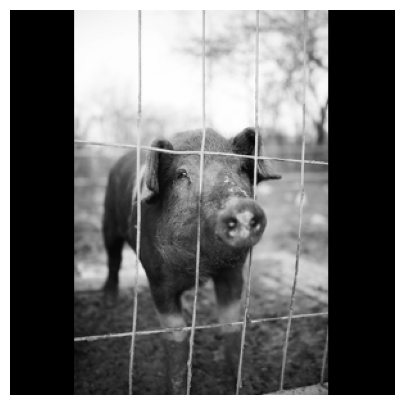

CPU times: user 292 ms, sys: 5.6 ms, total: 298 ms
Wall time: 96.7 ms
(1)  437 - beach wagon: 0.4731006324291229
(2)  582 - grille: 0.10089202970266342
(3)  512 - convertible: 0.0784217044711113
(4)  628 - limousine: 0.05583428218960762
(5)  480 - car wheel: 0.03867632895708084


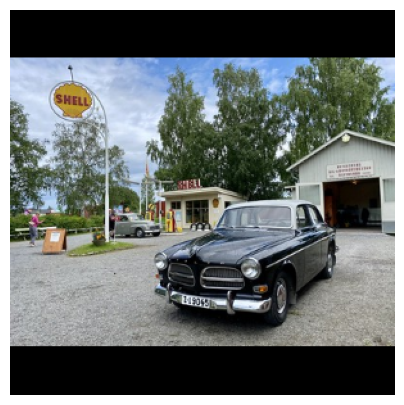

CPU times: user 274 ms, sys: 5.17 ms, total: 279 ms
Wall time: 90.5 ms
(1)  681 - nipple: 0.1885470598936081
(2)  530 - diaper: 0.12438807636499405
(3)  642 - maraca: 0.05884559080004692
(4)  444 - bib: 0.058235444128513336
(5)  930 - ice lolly: 0.03003501333296299


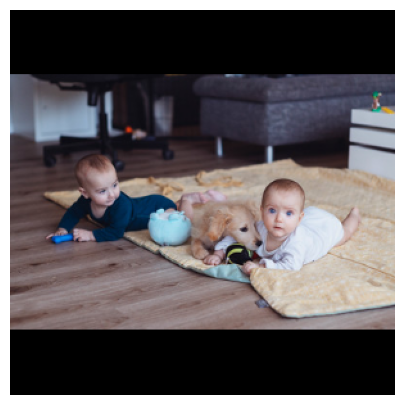

CPU times: user 90 ms, sys: 5.42 ms, total: 95.4 ms
Wall time: 28.9 ms
(1)  951 - orange: 0.8899514675140381
(2)  952 - lemon: 0.015166697092354298
(3)  955 - banana: 0.002397133968770504
(4)   16 - robin: 0.0011975860688835382
(5)  779 - scale: 0.0008483257261104882


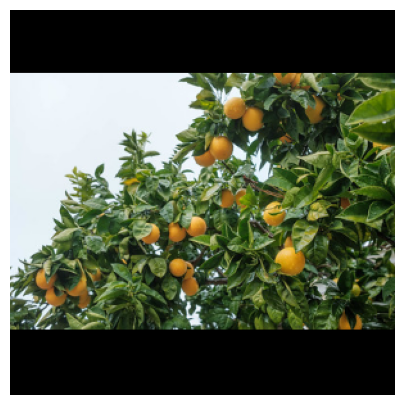

CPU times: user 119 ms, sys: 10.1 ms, total: 129 ms
Wall time: 40.5 ms
(1)  179 - Weimaraner: 0.2401108592748642
(2)  292 - lion: 0.12409801781177521
(3)  171 - Irish wolfhound: 0.08091218769550323
(4)  178 - Scottish deerhound: 0.05599406734108925
(5)  979 - seashore: 0.04805093631148338


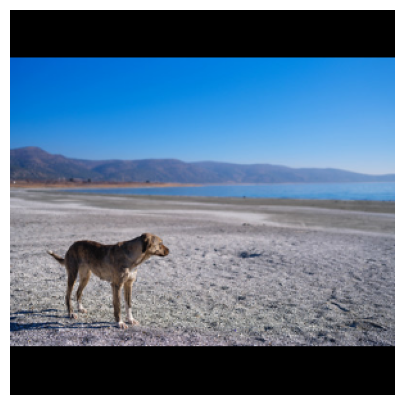

CPU times: user 93 ms, sys: 5.64 ms, total: 98.7 ms
Wall time: 30.1 ms
(1)  905 - window screen: 0.6571128964424133
(2)  286 - Egyptian cat: 0.2759619355201721
(3)  283 - tiger cat: 0.007581252604722977
(4)  842 - sweatshirt: 0.0037999122869223356
(5)  906 - window shade: 0.0035836943425238132


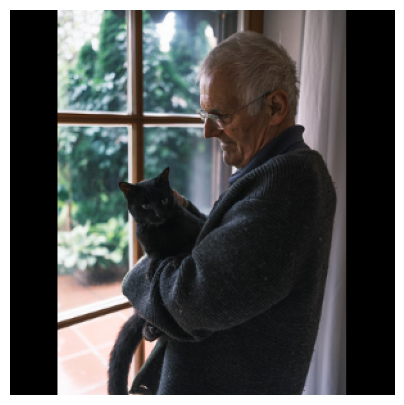

CPU times: user 87 ms, sys: 4.94 ms, total: 91.9 ms
Wall time: 28.8 ms
(1)  979 - seashore: 0.847150444984436
(2)  976 - lakeside: 0.07738682627677917
(3)  978 - sandbar: 0.0169227235019207
(4)  917 - web site: 0.007134897634387016
(5)  977 - promontory: 0.005373816005885601


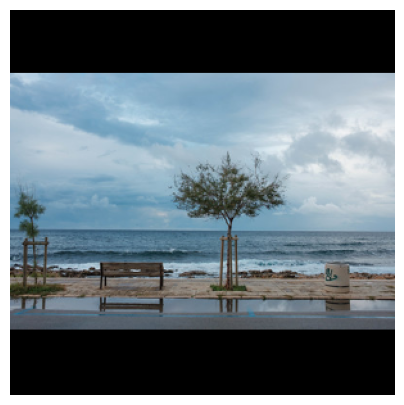

CPU times: user 88 ms, sys: 4.87 ms, total: 92.8 ms
Wall time: 28 ms
(1)  986 - daisy: 0.6396227478981018
(2)  310 - bee: 0.1656738668680191
(3)  309 - fly: 0.013282625935971737
(4)  325 - cabbage butterfly: 0.006123622879385948
(5)  947 - cardoon: 0.004599886480718851


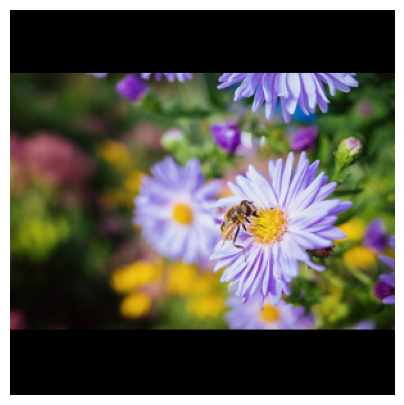

CPU times: user 88.8 ms, sys: 5.39 ms, total: 94.2 ms
Wall time: 29 ms
(1)  896 - warplane: 0.8054657578468323
(2)  909 - wing: 0.032124266028404236
(3)  405 - airliner: 0.030633581802248955
(4)  546 - electric fan: 0.01659010723233223
(5)  406 - airship: 0.014102759771049023


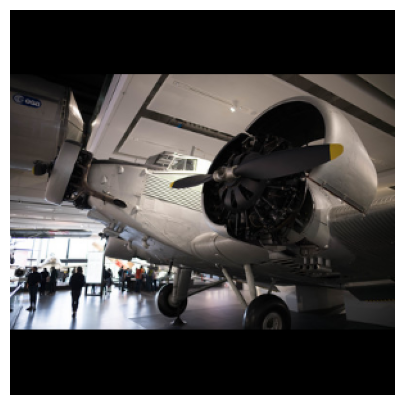

CPU times: user 114 ms, sys: 10.3 ms, total: 125 ms
Wall time: 55.4 ms
(1)  438 - beacon: 0.6284858584403992
(2)  584 - guillotine: 0.08994970470666885
(3)  867 - tractor: 0.022482022643089294
(4)  461 - breakwater: 0.01524055190384388
(5)  443 - bell cote: 0.013591893017292023


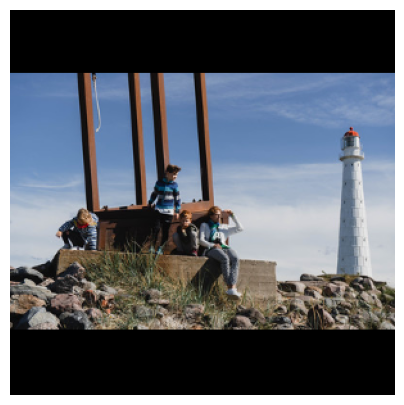

CPU times: user 91.6 ms, sys: 5.46 ms, total: 97 ms
Wall time: 29 ms
(1)  976 - lakeside: 0.20535442233085632
(2)  840 - suspension bridge: 0.09886213392019272
(3)  595 - harp: 0.03157106786966324
(4)  473 - canoe: 0.019491929560899734
(5)  563 - fountain: 0.017654823139309883


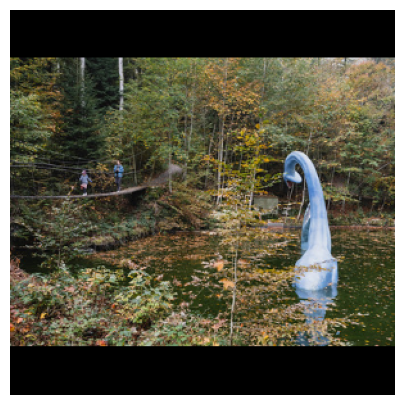

CPU times: user 88.8 ms, sys: 5.98 ms, total: 94.7 ms
Wall time: 28.9 ms
(1)  498 - church: 0.8063496947288513
(2)  443 - bell cote: 0.13213619589805603
(3)  664 - monastery: 0.008926600217819214
(4)  426 - barn: 0.005670551210641861
(5)  438 - beacon: 0.004674069117754698


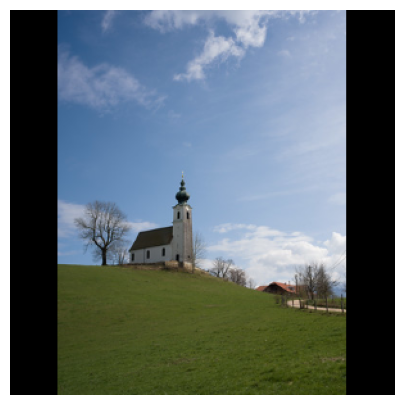

CPU times: user 84 ms, sys: 5.54 ms, total: 89.5 ms
Wall time: 28 ms
(1)  734 - pole: 0.8873656392097473
(2)  678 - nail: 0.02258511260151863
(3)  584 - guillotine: 0.0041870493441820145
(4)  635 - lumbermill: 0.0028823900502175093
(5)  717 - picket fence: 0.0024738118518143892


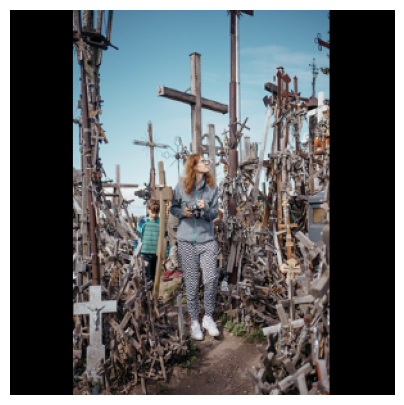

CPU times: user 126 ms, sys: 10.2 ms, total: 136 ms
Wall time: 43.4 ms
(1)  190 - Lakeland terrier: 0.3559548854827881
(2)  209 - Labrador retriever: 0.11540170758962631
(3)  976 - lakeside: 0.04754474759101868
(4)  204 - West Highland white terrier: 0.03461457043886185
(5)  152 - Chihuahua: 0.02956046350300312


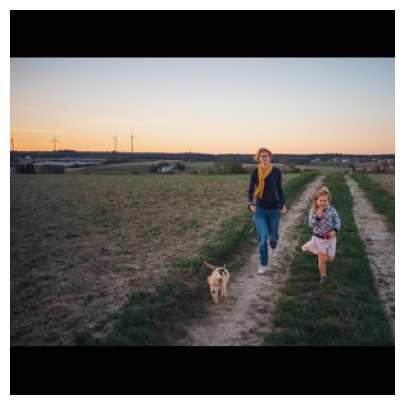

CPU times: user 87 ms, sys: 5.8 ms, total: 92.8 ms
Wall time: 28.6 ms
(1)  806 - soccer ball: 0.6709548830986023
(2)  891 - volleyball: 0.05383101850748062
(3)  769 - rugby ball: 0.039773404598236084
(4)  430 - baseball: 0.013395415619015694
(5)  523 - croquet ball: 0.00972316600382328


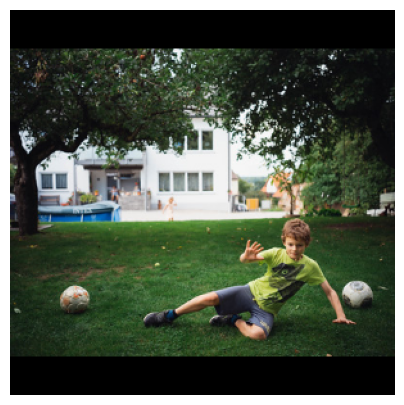

CPU times: user 90.8 ms, sys: 6.36 ms, total: 97.1 ms
Wall time: 29.4 ms
(1)  989 - acorn: 0.2305750548839569
(2)  953 - fig: 0.03657541796565056
(3)  951 - orange: 0.018159912899136543
(4)   91 - lorikeet: 0.018009072169661522
(5)  991 - buckeye: 0.017104320228099823


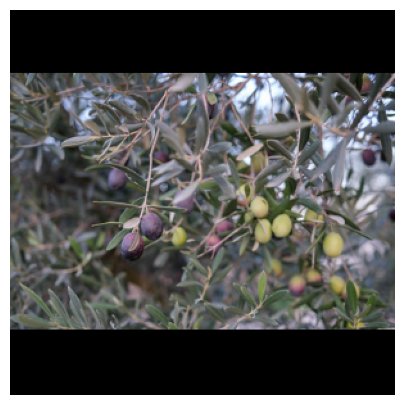

CPU times: user 83.8 ms, sys: 5.97 ms, total: 89.8 ms
Wall time: 27.8 ms
(1)  980 - valley: 0.3478988707065582
(2)  756 - radio telescope: 0.02912476658821106
(3)  868 - trailer truck: 0.026053324341773987
(4)  976 - lakeside: 0.025886716321110725
(5)  917 - web site: 0.025090113282203674


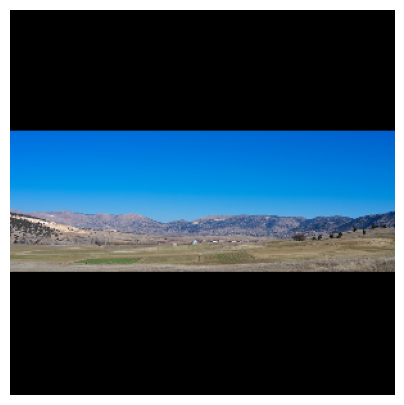

CPU times: user 91.6 ms, sys: 5.95 ms, total: 97.6 ms
Wall time: 29.5 ms
(1)  875 - trolleybus: 0.7335529923439026
(2)  830 - streetcar: 0.13409465551376343
(3)  706 - passenger car: 0.016936594620347023
(4)  655 - minibus: 0.003244079416617751
(5)  804 - snowplow: 0.0025573214516043663


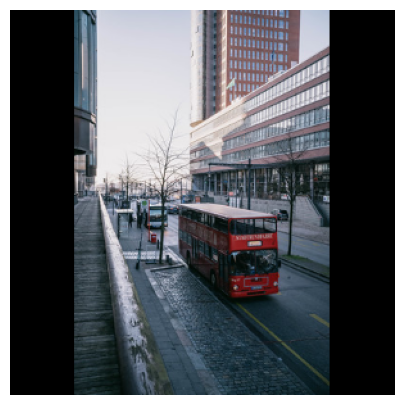

CPU times: user 83.5 ms, sys: 5.88 ms, total: 89.3 ms
Wall time: 27.9 ms
(1)  351 - ibex: 0.23621322214603424
(2)  346 - ox: 0.1578875035047531
(3)  350 - bighorn: 0.11159054934978485
(4)  347 - water buffalo: 0.035073280334472656
(5)  354 - gazelle: 0.01649116538465023


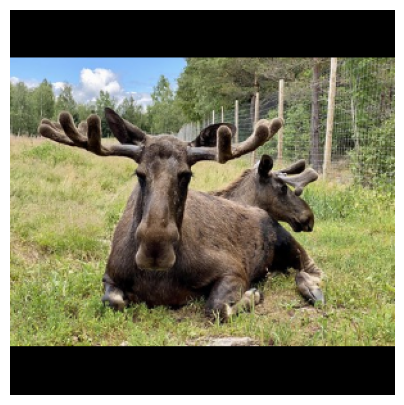

CPU times: user 82.9 ms, sys: 6.02 ms, total: 88.9 ms
Wall time: 27.4 ms
(1)  976 - lakeside: 0.759986162185669
(2)  979 - seashore: 0.0856415331363678
(3)  978 - sandbar: 0.02348960191011429
(4)  980 - valley: 0.009763096459209919
(5)  418 - balloon: 0.006631849333643913


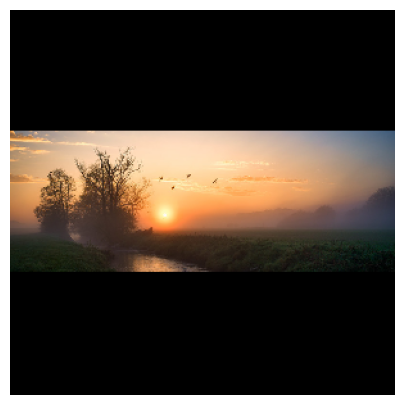

CPU times: user 89.7 ms, sys: 6.02 ms, total: 95.7 ms
Wall time: 29.1 ms
(1)   26 - European fire salamander: 0.8068580627441406
(2)   29 - spotted salamander: 0.030798278748989105
(3)   27 - common newt: 0.021710405126214027
(4)   33 - tailed frog: 0.01369728334248066
(5)   32 - tree frog: 0.0040201409719884396


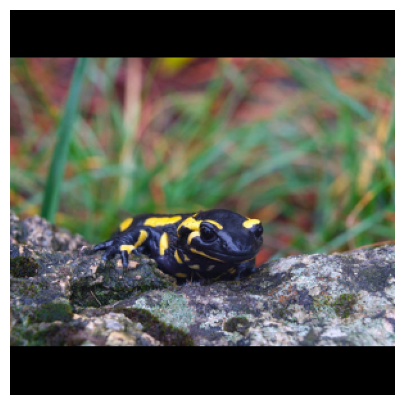

CPU times: user 90.3 ms, sys: 5.07 ms, total: 95.4 ms
Wall time: 29.4 ms
(1)  985 - rapeseed: 0.12390073388814926
(2)  976 - lakeside: 0.06757257878780365
(3)  702 - parachute: 0.03243480622768402
(4)  999 - ear: 0.03176203742623329
(5)  947 - cardoon: 0.020098524168133736


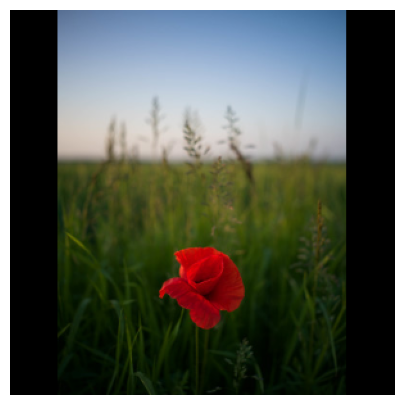

CPU times: user 89.4 ms, sys: 5.26 ms, total: 94.6 ms
Wall time: 28.8 ms
(1)  100 - goose: 0.8436635136604309
(2)   98 - drake: 0.025320017710328102
(3)   85 - peacock: 0.0035966585855931044
(4)  145 - pelican: 0.003032440086826682
(5)  976 - lakeside: 0.0023492188192903996


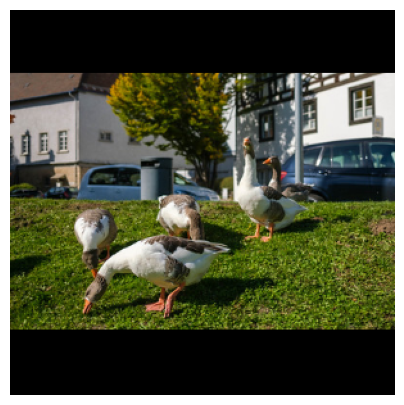

CPU times: user 118 ms, sys: 11.4 ms, total: 130 ms
Wall time: 43.8 ms
(1)  209 - Labrador retriever: 0.7075558304786682
(2)  190 - Lakeland terrier: 0.09214771538972855
(3)  212 - vizsla: 0.059044938534498215
(4)  208 - golden retriever: 0.01980689913034439
(5)  163 - beagle: 0.014148557558655739


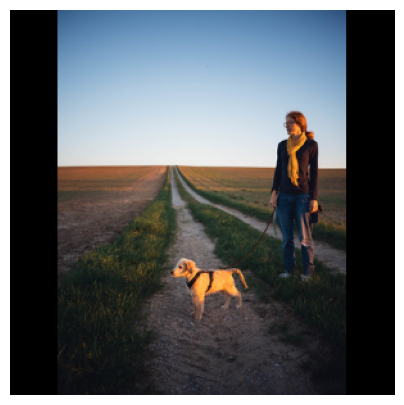

CPU times: user 85.8 ms, sys: 4.79 ms, total: 90.6 ms
Wall time: 28.1 ms
(1)  209 - Labrador retriever: 0.8768358826637268
(2)  208 - golden retriever: 0.08060317486524582
(3)  223 - kuvasz: 0.006342276465147734
(4)  168 - English foxhound: 0.0013093058951199055
(5)  167 - Walker hound: 0.0007742259185761213


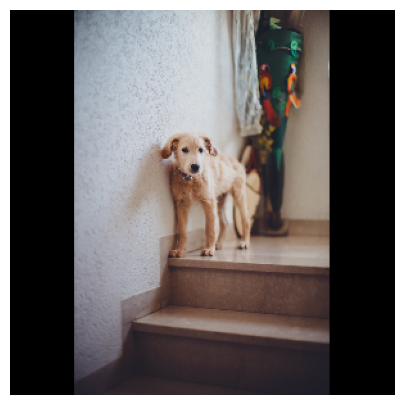

CPU times: user 97.9 ms, sys: 8.76 ms, total: 107 ms
Wall time: 32.1 ms
(1)  979 - seashore: 0.17767956852912903
(2)  719 - pier: 0.12063241004943848
(3)  537 - dock: 0.10011089593172073
(4)  461 - breakwater: 0.042286474257707596
(5)  450 - boathouse: 0.03728372976183891


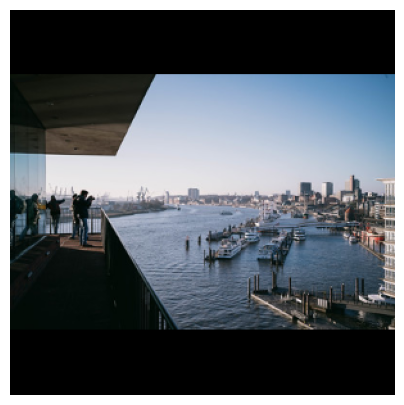

CPU times: user 156 ms, sys: 8.92 ms, total: 165 ms
Wall time: 51.9 ms
(1)  429 - barrow: 0.29604199528694153
(2)  793 - shovel: 0.1327352672815323
(3)  731 - plow: 0.06610243022441864
(4)  581 - greenhouse: 0.03767286613583565
(5)  867 - tractor: 0.020442094653844833


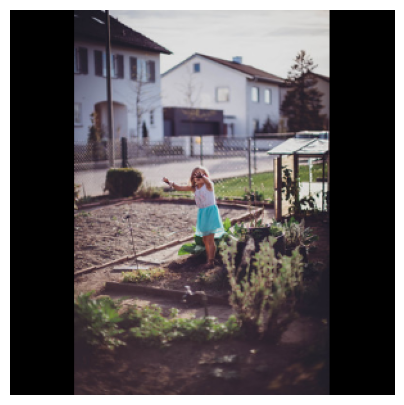

CPU times: user 91.2 ms, sys: 5.6 ms, total: 96.8 ms
Wall time: 29.4 ms
(1)  947 - cardoon: 0.22601880133152008
(2)  302 - ladybug: 0.1083996444940567
(3)  945 - artichoke: 0.04876105487346649
(4)  311 - ant: 0.04499375820159912
(5)  997 - hen-of-the-woods: 0.0394277349114418


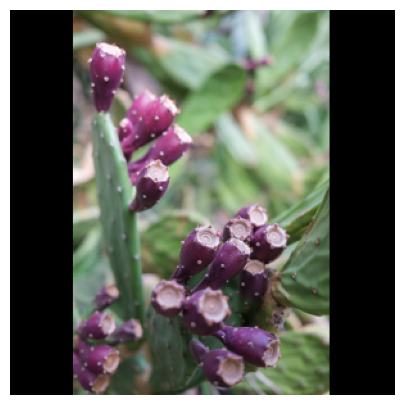

In [70]:
for image_path in image_list:
    img_url = image_path
    image, original_image = load_image(img_url, image_size, dynamic_size, max_dynamic_size)
    #show_image(image, 'Scaled image')

    # Run model on image
    %time probabilities = tf.nn.softmax(classifier(image)).numpy()

    top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
    np_classes = np.array(classes)

    # Some models include an additional 'background' class in the predictions, so
    # we must account for this when reading the class labels.
    includes_background_class = probabilities.shape[1] == 1001

    term, prob = [], []

    for i, item in enumerate(top_5):
      class_index = item if includes_background_class else item + 1
      line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
      term.append(classes[class_index])
      prob.append(probabilities[0][top_5][i])
      print(line)
      #print(term, prob)

    df.loc[len(df)] = ['img_url', 'img_url', term[0], prob[0],  term[1], prob[1],  term[2], prob[2],  term[3], prob[3],  term[4], prob[4]]

    show_image(image, '')

In [71]:
df.head(20)

id filename             term1     prob1               term2  \
0   img_url  img_url               hog  0.780199           wild boar   
1   img_url  img_url       beach wagon  0.473101              grille   
2   img_url  img_url            nipple  0.188547              diaper   
3   img_url  img_url            orange  0.889951               lemon   
4   img_url  img_url        Weimaraner  0.240111                lion   
5   img_url  img_url     window screen  0.657113        Egyptian cat   
6   img_url  img_url          seashore  0.847150            lakeside   
7   img_url  img_url             daisy  0.639623                 bee   
8   img_url  img_url          warplane  0.805466                wing   
9   img_url  img_url            beacon  0.628486          guillotine   
10  img_url  img_url          lakeside  0.205354   suspension bridge   
11  img_url  img_url            church  0.806350           bell cote   
12  img_url  img_url              pole  0.887366                nail   
13  img_url  img_url  Lakeland terrier  0.355955  Labrador retriever   
14  img_url  img_url       soccer ball  0.670955          volleyball   
15  img_url  img_url             acorn  0.230575                 fig   
16  img_url  img_url            valley  0.347899     radio telescope   
17  img_url  img_url        trolleybus  0.733553           streetcar   
18  img_url  img_url              ibex  0.236213                  ox   
19  img_url  img_url          lakeside  0.759986            seashore   

       prob2            term3     prob3                        term4  \
0   0.133194       piggy bank  0.002379                      warthog   
1   0.100892      convertible  0.078422                    limousine   
2   0.124388           maraca  0.058846                          bib   
3   0.015167           banana  0.002397                        robin   
4   0.124098  Irish wolfhound  0.080912           Scottish deerhound   
5   0.275962        tiger cat  0.007581                   sweatshirt   
6   0.077387          sandbar  0.016923                     web site   
7   0.165674              fly  0.013283            cabbage butterfly   
8   0.032124         airliner  0.030634                 electric fan   
9   0.089950          tractor  0.022482                   breakwater   
10  0.098862             harp  0.031571                        canoe   
11  0.132136        monastery  0.008927                         barn   
12  0.022585       guillotine  0.004187                   lumbermill   
13  0.115402         lakeside  0.047545  West Highland white terrier   
14  0.053831       rugby ball  0.039773                     baseball   
15  0.036575           orange  0.018160                     lorikeet   
16  0.029125    trailer truck  0.026053                     lakeside   
17  0.134095    passenger car  0.016937                      minibus   
18  0.157888          bighorn  0.111591                water buffalo   
19  0.085642          sandbar  0.023490                       valley   

       prob4         term5     prob5  
0   0.002014    worm fence  0.001785  
1   0.055834     car wheel  0.038676  
2   0.058235     ice lolly  0.030035  
3   0.001198         scale  0.000848  
4   0.055994      seashore  0.048051  
5   0.003800  window shade  0.003584  
6   0.007135    promontory  0.005374  
7   0.006124       cardoon  0.004600  
8   0.016590       airship  0.014103  
9   0.015241     bell cote  0.013592  
10  0.019492      fountain  0.017655  
11  0.005671        beacon  0.004674  
12  0.002882  picket fence  0.002474  
13  0.034615     Chihuahua  0.029560  
14  0.013395  croquet ball  0.009723  
15  0.018009       buckeye  0.017104  
16  0.025887      web site  0.025090  
17  0.003244      snowplow  0.002557  
18  0.035073       gazelle  0.016491  
19  0.009763       balloon  0.006632